# TEXT CLASSIFICATION

The following cell contains some predefined functions to implement text featurization and classification. 

In [23]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [1]:
def featDataset(dataset):
    output=dataset[:-4]+'_Vectorized.txt'
    with open(output,"w") as w:
        with open(dataset,encoding='utf-8', mode = 'r') as f:
            data=f.readlines()
            text=[entry.split('\t')[1].rstrip() for entry in data[1:]]
            labels=[entry.split('\t')[0] for entry in data[1:]]
            parsedText=list(map(textParse,text))
            vocabList=createVocabList(parsedText)
            for word in vocabList:
                w.write(word+',')
            w.write('class\n')
            for i in range(len(labels)):
                returnVec=setOfWords2Vec(vocabList,parsedText[i])
                for num in returnVec:
                    w.write(str(num)+',')
                w.write(labels[i]+"\n")
            return vocabList

def createVocabList(dataSet):
    vocabSet=set([])
    for document in dataSet:
        vocabSet=vocabSet|set(document)
    return list(vocabSet)

def textParse(bigString):
    import re
    
    listOfTokens=re.split(r'[^A-Za-z]+',bigString)
    return [tok.lower() for tok in listOfTokens if len(tok)>2]

def setOfWords2Vec(vocabList,inputSet):
    returnVec=[0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)]=1
        else: print('the word: %s is not in my Vocabulary' % word)
    return returnVec

def loadDataSet(dataset):
    with open(dataset) as f:
        data=f.readlines()
        attributes=data[0].rstrip().split(',')[:-1]
        #print("attributes",len(attributes))
        instances=[entry.rstrip().split(',')[:-1] for entry in data[1:]]
        dataArray=[]
        for i in range(len(instances[0])):
            try:
                dataArray.append([float(instance[i]) for instance in instances])
            except:
                encodedData,codeBook=encode([instance[i] for instance in instances])
                dataArray.append(encodedData)
                print(attributes[i],': ',list(codeBook.items()))
        instances=np.array(dataArray).T
        labels=[entry.rstrip().split(',')[-1] for entry in data[1:]]
        return instances,labels

def evaluateClf(clf,instances,labels,n_foldCV):
    for item in clf:
        if type(item).__name__=="BernoulliNB":
            scores = cross_val_score(item, instances, labels, cv=n_foldCV)
            print("======BernoulliNB======")
            print(scores)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        elif type(item).__name__=="GaussianNB":
            scores = cross_val_score(item, instances, labels, cv=n_foldCV)
            print("======GaussianNB======")
            print(scores)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        elif type(item).__name__=="MultinomialNB":
            scores = cross_val_score(item, instances, labels, cv=n_foldCV)
            print("======MultinomialNB======")
            print(scores)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def predict(testset):
    if "clf_G" in globals():
        prediction=clf_G.predict(testset)
        print("GaussianNB: ",prediction)

## Explore the data


In [3]:
dataset = 'SMSSpamCollection'
df=pd.read_csv(dataset,sep='\t',header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: xlabel='0'>

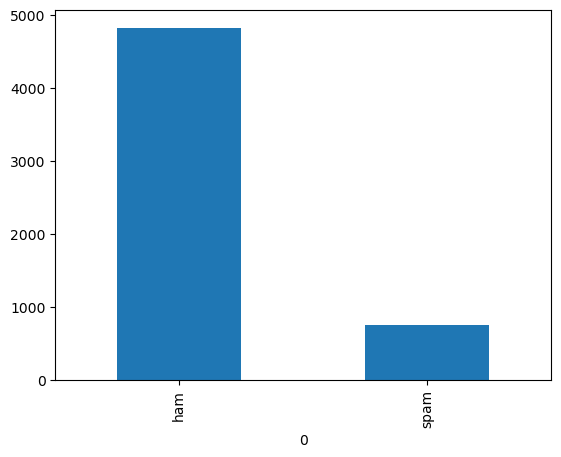

In [4]:
df[0].value_counts().plot(kind='bar')

In [5]:
df[0].value_counts()

0
ham     4825
spam     747
Name: count, dtype: int64

The classes are imbalanced, which could be a problem for the training as the algorithm will see more instances of not spam than spam. 

## feature encoding

First, let's create a list of all the words that appear in all the documents. That list will enable us to create a **vector** for each document where each element of the vector corresponds to a word in that list. For a given instance, each element is a 1 if that word is in the instance and a 0 if it is not.  


In [7]:
two_pieces_text=list(map(textParse,["please parse the text","this is second test to parse"]))
vocabList=createVocabList(two_pieces_text)
featurized_vectors=pd.DataFrame([setOfWords2Vec(vocabList,instance) for instance in two_pieces_text],columns=vocabList,\
                               index=["Text 1","Text 2"])
display(featurized_vectors)

,parse,test,this,please,second,the,text
Text 1,1,0,0,1,0,1,1
Text 2,1,1,1,0,1,0,0


## Preprocess the document to identify all the words
Before we encode the text, let's generate and display the vocabulary list.

In [8]:
text=[instance.rstrip() for instance in df.iloc[:,1]]
parsedText=list(map(textParse,text))
vocabList=createVocabList(parsedText)
print('Vocabulary List: \n',vocabList)
print(len(vocabList))

Vocabulary List: 
7476


## Generate features for the documents##
For each document, we generate a feature vector which records the appearance of each word in the vocabulary list. 
Let's test it for first document.



In [9]:
vec = []
for instance in parsedText:
    vec.append(setOfWords2Vec(vocabList,instance))
print(vec[0])

## Training and testing a Naïve Bayes Classifier

In [11]:
instances = np.array(vec)
labels = df[0]
idx_spam = [i for i, j in enumerate(labels) if j == 'spam']
idx_ham = [i for i, j in enumerate(labels) if j == 'ham']
Xs_Train, Xs_test, Ys_train, Ys_test = train_test_split(instances[idx_spam], np.array(labels)[idx_spam], test_size=0.25, random_state=24)
Xh_Train, Xh_test, Yh_train, Yh_test = train_test_split(instances[idx_ham], np.array(labels)[idx_ham], test_size=0.25, random_state=24)

In [12]:
X_train=np.append(Xs_Train,Xh_Train, axis=0)
X_test=np.append(Xs_test,Xh_test, axis=0)
Y_train=np.append(Ys_train,Yh_train)
Y_test=np.append(Ys_test,Yh_test)

I have chosen multinomial NB because labels are categorical

In [15]:

clf_G = MultinomialNB()
clf_G.fit(X_train, Y_train)

MultinomialNB()

In [16]:
prediction=clf_G.predict(X_test)
accuracy_score(Y_test,prediction)

0.9713055954088953

# Predicting unseen data
**Test set vectorization**  

In [26]:
testset=input('Please enter the text message that you want to test:')
returnVec=setOfWords2Vec(vocabList,textParse(testset))
print(returnVec)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
testset=np.array(returnVec).reshape(1, -1)
predict(testset)

GaussianNB:  ['spam']
